In [1]:
from __future__ import print_function
import sys
import os
import numpy as np
import google.protobuf as pb
import IPython.display as display
from os.path import expanduser, join
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# caffe paths and import
home_dir = expanduser('~')
caffe_root = os.path.join(home_dir, 'code/caffe')
sys.path.append(join(caffe_root, "python"))
import caffe
import caffe.draw

In [3]:
# download pre-trained model
if not os.path.isfile(join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

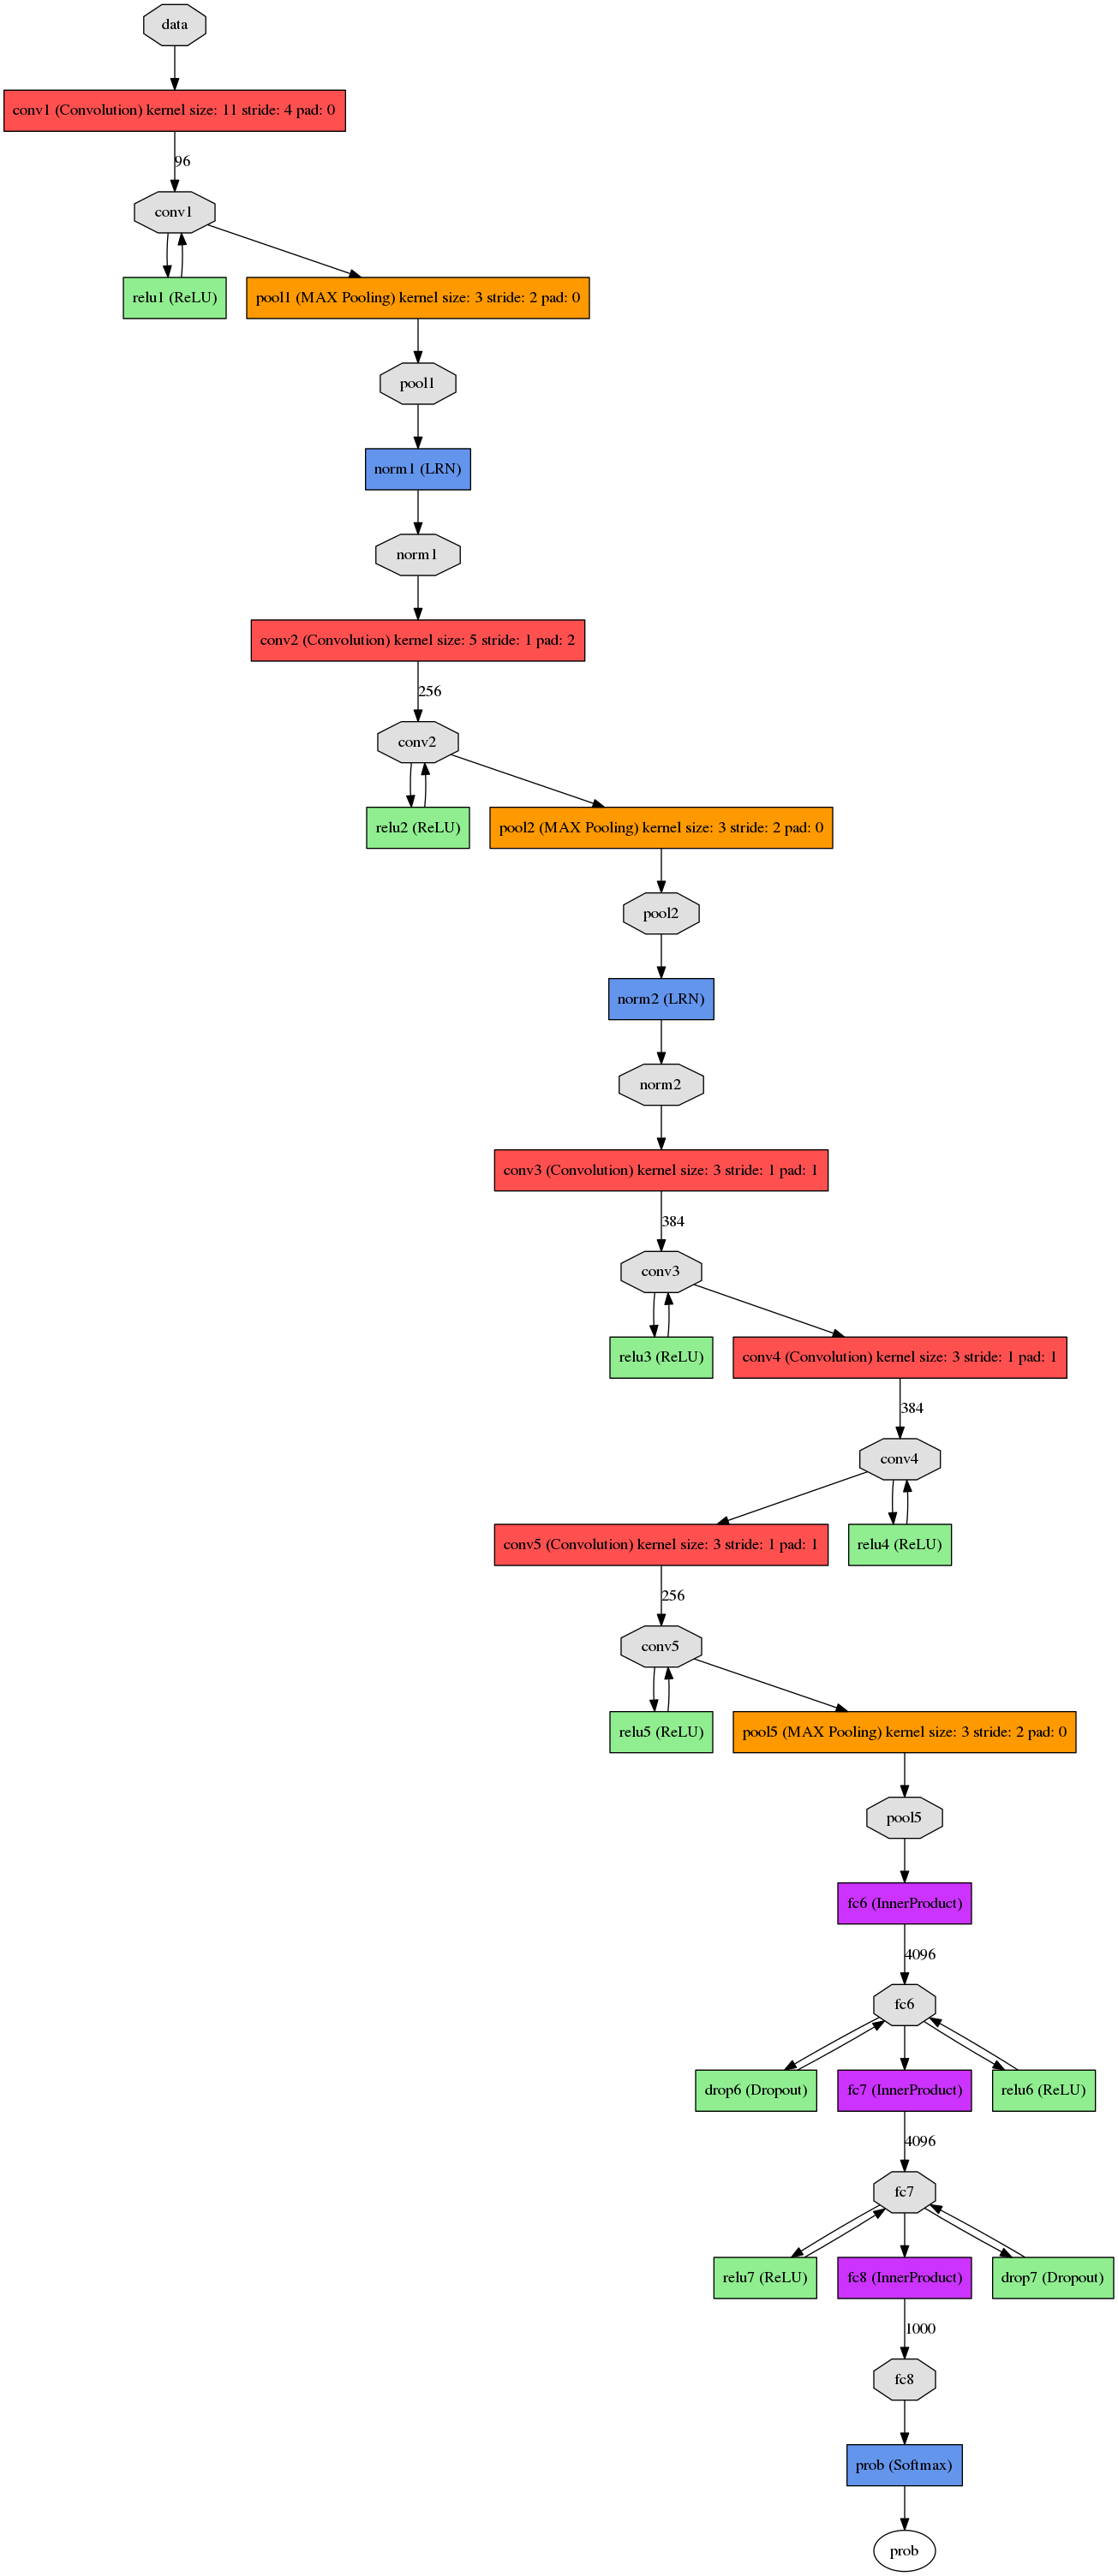

In [4]:
# plot net
def plot_net(file_path):
    net = caffe.proto.caffe_pb2.NetParameter()
    f = open(file_path)
    pb.text_format.Merge(f.read(), net)
    f.close()
    display.display(display.Image(caffe.draw.get_pydot_graph(net, "TB").create_png()))
    
plot_net(join(caffe_root, "models/bvlc_reference_caffenet/deploy.prototxt"))

In [5]:
# init net
caffe.set_mode_gpu()
caffe.set_device(1);
net = caffe.Net(join(caffe_root, 'models/bvlc_reference_caffenet/deploy.prototxt'),
                join(caffe_root, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'),
                caffe.TEST)

# set net to batch size of 50
net.blobs['data'].reshape(50,3,227,227)

In [6]:
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))

# mean pixel
im_mean = np.load(join(caffe_root, 'python/caffe/imagenet/ilsvrc_2012_mean.npy'))
transformer.set_mean('data', im_mean.mean(1).mean(1))

# the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_raw_scale('data', 255)

# the reference model has channels in BGR order instead of RGB
transformer.set_channel_swap('data', (2,1,0))

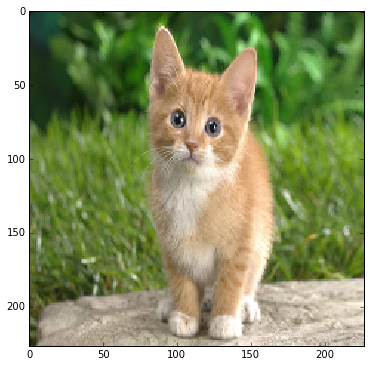

In [7]:
# feed image
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(join(caffe_root, 'examples/images/cat.jpg')))
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [8]:
# predict
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))
# or referenced from net.blobs['prob'].data
print("Predicted class is #{}.".format(net.blobs['prob'].data[0].argmax()))

Predicted class is #281.
Predicted class is #281.


In [9]:
# load labels
imagenet_labels_filename = join(caffe_root, 'data/ilsvrc12/synset_words.txt')
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print(labels[top_k])

['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']


In [10]:
# time
%timeit net.forward()

10 loops, best of 3: 42.1 ms per loop


In [11]:
# data or feature maps
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (50, 3, 227, 227)),
 ('conv1', (50, 96, 55, 55)),
 ('pool1', (50, 96, 27, 27)),
 ('norm1', (50, 96, 27, 27)),
 ('conv2', (50, 256, 27, 27)),
 ('pool2', (50, 256, 13, 13)),
 ('norm2', (50, 256, 13, 13)),
 ('conv3', (50, 384, 13, 13)),
 ('conv4', (50, 384, 13, 13)),
 ('conv5', (50, 256, 13, 13)),
 ('pool5', (50, 256, 6, 6)),
 ('fc6', (50, 4096)),
 ('fc7', (50, 4096)),
 ('fc8', (50, 1000)),
 ('prob', (50, 1000))]

In [12]:
# parameters
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (1000, 4096))]

In [13]:
print(net.params['conv2'][0].data.shape)
print(net.params['conv2'][1].data.shape)

(256, 48, 5, 5)
(256,)


In [14]:
def vis_square(data, padsize=1, padval=0):
    """
    Visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
    
    Input:
        data: array of shape (n, height, width) or (n, height, width, channels)
    
    Notes:
        required     : (n * h * w * c)
        caffe default: (n * c * h * w)
        do transpose : filter.transpose(0, 2, 3, 1)
    """
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

(96, 3, 11, 11)
(96,)


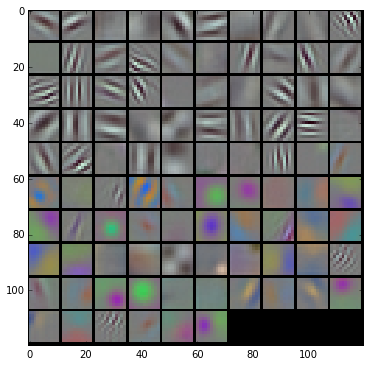

In [15]:
# parameters conv1
# weights
print(net.params['conv1'][0].data.shape)

# biases
print(net.params['conv1'][1].data.shape)

# visulize weights
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

(50, 96, 55, 55)
(36, 55, 55)


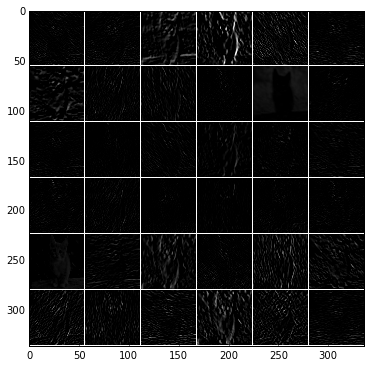

In [16]:
# feature maps conv1
# output shape
print(net.blobs['conv1'].data.shape)

# output feature maps
feat = net.blobs['conv1'].data[0, :36]
print(feat.shape)
vis_square(feat, padval=1)

In [17]:
# weights
print(net.params['conv1'][0].data.shape)

(96, 3, 11, 11)


(256, 48, 5, 5)


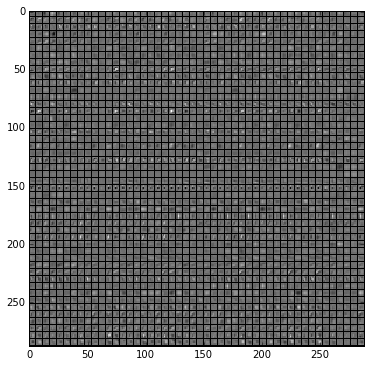

In [18]:
# parameters conv2
# weights
print(net.params['conv2'][0].data.shape)

filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

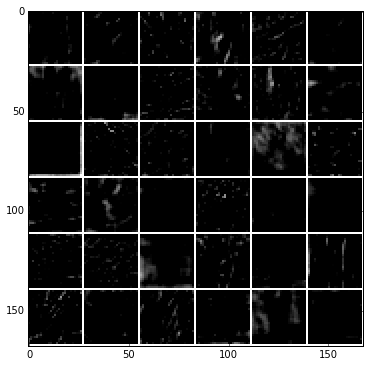

In [19]:
# conv2 outputs
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

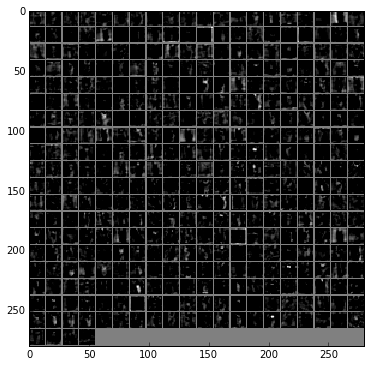

In [20]:
# conv3 outputs
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

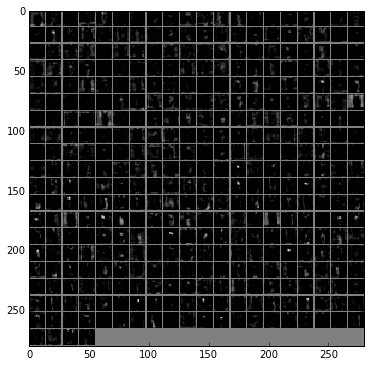

In [21]:
# conv4 outputs
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

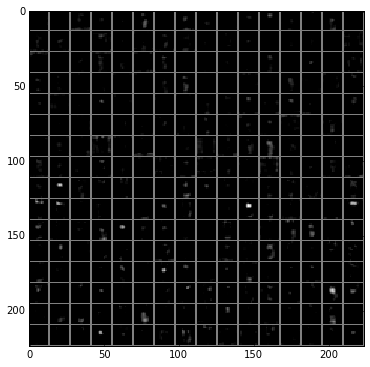

In [22]:
# conv5 outputs
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

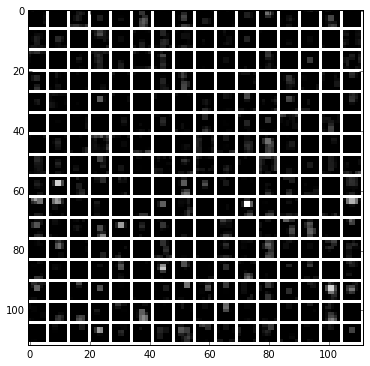

In [23]:
# pool5 outputs
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

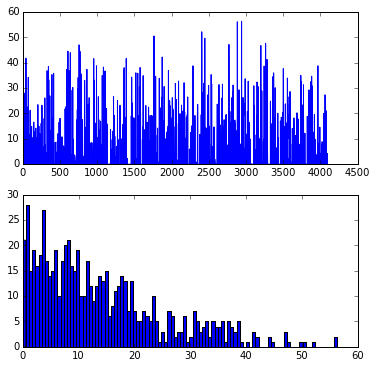

In [24]:
# fc6 histogram
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

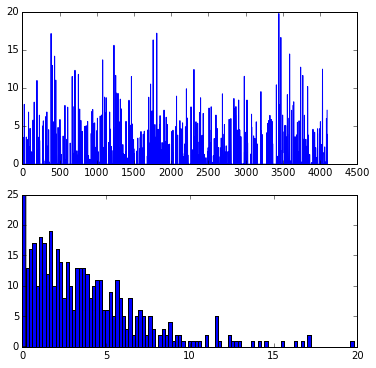

In [25]:
# fc7 histogram
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

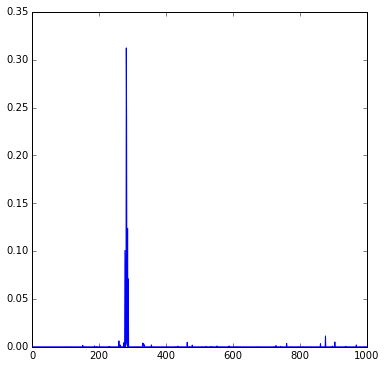

In [26]:
# 1,000 class output probability
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)